# Train a model to extract a baseline CNN weights for the task of classifying spectrums

The goal here is to train a model, that does 'well enough' on the dataset. Training just the classifier part with the bottleneck features of InceptionV3 does not yield usable result, meaning that the feautre extraction that works on normal photos does not work on spectrograms.

Training the model with InceptionV3 as a base, and an arbitrary classifier part will modify InceptionV3 in a way that is able to extract features from spectrograms. By saving these weights, it'll be possible to train classifier parts on the bottleneck features. This will allow me to perform hyperoptimization on the classfier part, select the best structure, and then fine tune the final model (InceptionV3 - with the wieghts trained here - and the selected classifier structure). To summarise, the steps I'll be taking are the following:


1.   Pretrain InceptionV3 with an arbitrary classifier part to learn feauture extraction for spectrograms
2.   Use the pretrained InceptionV3 to generate bottleneck features
3.   Perform hyperparameter optimizaton on the classifier network using the bottleneck features
4.   Select the best classifier structure
5.   Pretrain the selected classifier structure on the bottleneck features
6.   Put together the pretrained InceptionV3 and classifier
7.   TTrain the whole network to fine-tune everything





## 0. Prepare data
Mount my drive and extract the spectrograms to be used on Google Collab for training.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/DeepStep_colab/deepStep_data_spect.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace data_spect/test/Cicca/Cicca_boots_19.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Define the folder paths to use during training. 



In [0]:
import os

base_dir = 'data_spect'

train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

Display some of the spectrograms to check if everything is fine.

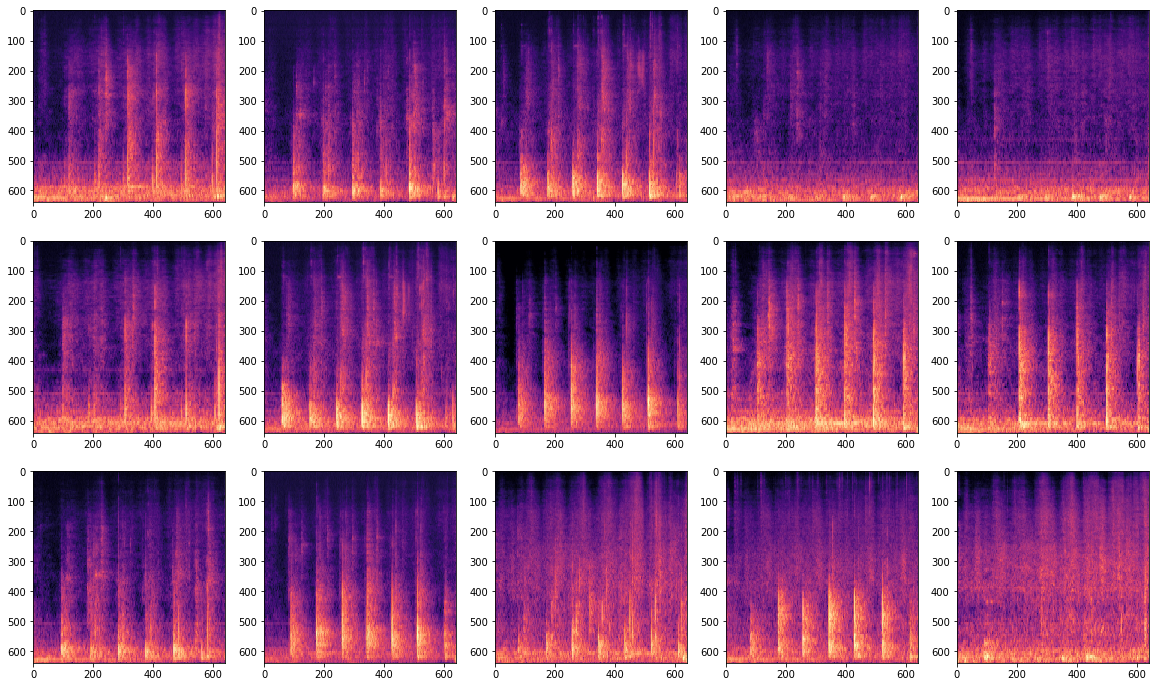

In [0]:
import matplotlib.pyplot as plt
from matplotlib import image

nrows = 3
ncols = 5

fig = plt.figure()
fig.set_size_inches(ncols * 4, nrows * 4)

# Organize the file names to a list
fnames = [os.path.join(path, fname) for path, dirs, files in os.walk(base_dir) for fname in files]

# Plot some of the spectrograms
for i, img_path in enumerate(fnames[:int(ncols*nrows)]):
    sp = plt.subplot(nrows, ncols, i+1)
    img = image.imread(img_path)
    plt.imshow(img)

plt.show()
plt.close()

Use the built in InceptionV3 image preprocessing method as a basis for creating data generators.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Use the built in InceptionV3 image preprocessing method
imDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)

Using TensorFlow backend.


Create the data generator to use during training.

In [0]:
train_generator = imDataGen.flow_from_directory(directory = train_dir,
                                                    target_size = (259, 259),
                                                    shuffle = True,
                                                    batch_size = 64, #Default batch size of 32 will not divied 1200, but we want to use all 1200 images to validate --> batch size of 16 will yield 75 batches
                                                    class_mode = 'categorical')

validate_generator = imDataGen.flow_from_directory(directory = validate_dir,
                                                       target_size = (259, 259),
                                                       shuffle = True,
                                                       batch_size = 8, #Default batch size of 32 will not divied 300, but we want to use all 300 images to validate --> batch size of 4 will yield 75 batches
                                                       class_mode = 'categorical')

test_generator = imDataGen.flow_from_directory(directory = test_dir,
                                                       target_size = (259, 259),
                                                       shuffle = False,
                                                       batch_size = 1, #Default batch size of 32 will not divied 300, but we want to use all 300 images to validate --> batch size of 4 will yield 75 batches
                                                       class_mode = 'categorical')

Found 512 images belonging to 6 classes.
Found 64 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


## 1. Build the network

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

Building the full model.

*NOTE*: I'm not using dropout/BatchNorm in this classification model, because I'm not too concerned about owerfitting yet. This part will be replaced anyway, the point here is to train the feature extraction part to use in transfer learning later.

In [0]:
def build_class_model(input_shape):
    model = Sequential(name = 'classification')

    model.add(Flatten(input_shape = input_shape))
    model.add(Dense(126, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(6, activation='softmax')) # Softmax for classification

    return model

In [0]:
def build_full_model():
    model = Sequential(name = 'DeepStep')

    # Add InceptionV3 as the bottom part of the network. Original uses input shape of 299x299, but 259x259 suits the spectrograms better
    model_InV3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (259, 259, 3))
    model.add(model_InV3)
  
    class_model = build_class_model(model_InV3.output_shape[1:])
    model.add(class_model)

    return model

In [0]:
deepStep_model = build_full_model()

## 2. Pretrain the model
Use the adam optimzer to perfrom a coarse training of the model.

In [0]:
# Compile model to learn with adam
deepStep_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
deepStep_model.summary()



Model: "DeepStep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
classification (Sequential)  (None, 6)                 9294116   
Total params: 31,096,900
Trainable params: 31,062,468
Non-trainable params: 34,432
_________________________________________________________________


Callbacks for the full model training:

In [0]:
# Monitor validation accuracy as our benchmark metric in this training:
early_stopping = EarlyStopping(monitor='val_acc', patience = 50, restore_best_weights = True, verbose = 1)
# Save the best model of rough training to my drive.
checkpointer =  ModelCheckpoint(filepath = '/content/drive/My Drive/DeepStep_colab/PreTraining/DeepStep_model_rough_training.hdf5', monitor='val_acc', save_best_only = True)
# Save a log of training to my drive
logger = CSVLogger('/content/drive/My Drive/DeepStep_colab/PreTraining/DeepStep_model_rough_training.log.txt')

Train the model with adam:

In [0]:
history_rough = deepStep_model.fit_generator(train_generator,
                                             epochs = 1000,
                                             verbose = 1,
                                             shuffle = True,
                                             validation_data = validate_generator,
                                             callbacks = [checkpointer, early_stopping, logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1000
8/8 [==============================] - 34s 4s/step - loss: 4.1765 - acc: 0.2324 - val_loss: 6.2031 - val_acc: 0.0938
Epoch 2/1000
8/8 [==============================] - 8s 958ms/step - loss: 1.8548 - acc: 0.3125 - val_loss: 10.7454 - val_acc: 0.0469
Epoch 3/1000
8/8 [==============================] - 8s 970ms/step - loss: 1.7373 - acc: 0.3770 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/1000
8/8 [==============================] - 8s 962ms/step - loss: 1.3072 - acc: 0.5703 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/1000
8/8 [==============================] - 8s 966ms/step - loss: 1.0946 - acc: 0.7051 - val_loss: 8.6780 - val_acc: 0.2344
Epoch 6/1000
8/8 [==============================] - 8s 962ms/step - loss: 0.8036 - acc: 0.7422 - val_loss: 8.4413 - val_acc: 0.3750
Epoch 7/1000
8/8 [==============================] - 8s 963ms/step - loss: 0.8019 - acc: 0.8613 - val_loss: 12.8

Continue to 'fine-tune' the model with a lower learning rate, and the Momentum optimizer instead of Adam, because at the later stages, training with adam causes a lot of oscillations.

In [0]:
deepStep_model.compile(optimizer = SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

Use loss as the benchmark metric here, as at this point accuracy improves much less often, loss has 'higher resolution' in terms of the model performance. Define the callbacks accordingly.

In [0]:
# Monitor validation accuracy as our benchmark metric in this training:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True, verbose = 1)
# Save the best model of rough training to my drive.
checkpointer =  ModelCheckpoint(filepath = '/content/drive/My Drive/DeepStep_colab/PreTraining/DeepStep_model_fine_training.hdf5', monitor='val_loss', save_best_only = True)
# Save a log of training to my drive
logger = CSVLogger('/content/drive/My Drive/DeepStep_colab/PreTraining/DeepStep_model_fine_training.log.txt')

In [0]:
history_fine = deepStep_model.fit_generator(train_generator,
                                            epochs = 1000,
                                            verbose = 1,
                                            shuffle = True,
                                            validation_data = validate_generator,
                                            callbacks = [checkpointer, early_stopping, logger])

Epoch 1/1000
8/8 [==============================] - 26s 3s/step - loss: 1.9399e-05 - acc: 1.0000 - val_loss: 4.5594 - val_acc: 0.4375
Epoch 2/1000
8/8 [==============================] - 7s 931ms/step - loss: 5.4074e-05 - acc: 1.0000 - val_loss: 4.2479 - val_acc: 0.4375
Epoch 3/1000
8/8 [==============================] - 8s 939ms/step - loss: 0.0159 - acc: 0.9980 - val_loss: 3.7134 - val_acc: 0.4375
Epoch 4/1000
8/8 [==============================] - 8s 940ms/step - loss: 1.6162e-05 - acc: 1.0000 - val_loss: 3.4194 - val_acc: 0.4375
Epoch 5/1000
8/8 [==============================] - 8s 939ms/step - loss: 7.5900e-04 - acc: 1.0000 - val_loss: 3.0683 - val_acc: 0.4375
Epoch 6/1000
8/8 [==============================] - 7s 936ms/step - loss: 0.0023 - acc: 0.9980 - val_loss: 2.7238 - val_acc: 0.4375
Epoch 7/1000
8/8 [==============================] - 8s 942ms/step - loss: 7.8868e-04 - acc: 1.0000 - val_loss: 2.3583 - val_acc: 0.4844
Epoch 8/1000
8/8 [==============================] - 8s 938

Finally, save the weight of the pretrained InceptionV3

In [0]:
deepStep_model.layers[0].save_weights('/content/drive/My Drive/DeepStep_colab/InceptionV3_spectrogram_pretrained_weights.hdf5')

## 3. Evaluate the model after pretraining

Plot the training history.

*NOTE*: The batch normalization layers have some weird behaviour when continuing to train a model. This is the reason we see a drop in the performance right at the beginning of fine training compared to the best epoch of the rough training. 

In retrospect, the fine-training was unnecessary, as training with adam already achieved a 'perfect' score even on the validation data. All the fine_training did (theoretically) was to restore the non-trainable parameters of the batch-normalization layers to their state they were in the best epoch of the rough training.

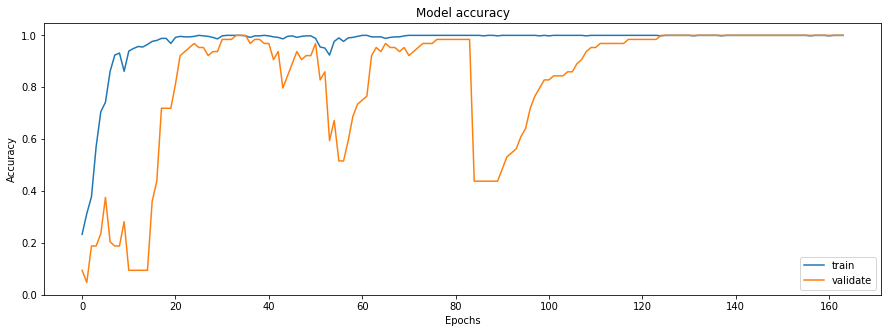

In [0]:
import numpy as np

# Plot model accuracy
plt.figure(figsize = (15,5))

plt.plot(np.append(history_rough.history['acc'],history_fine.history['acc']))
plt.plot(np.append(history_rough.history['val_acc'],history_fine.history['val_acc']))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()
plt.close()

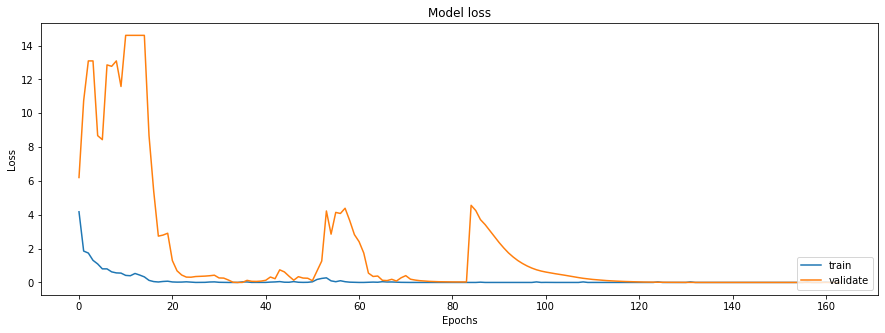

In [0]:
# Plot model loss
plt.figure(figsize = (15,5))

plt.plot(np.append(history_rough.history['loss'],history_fine.history['loss']))
plt.plot(np.append(history_rough.history['val_loss'],history_fine.history['val_loss']))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()

Evaluate accuracy and loss on the test dataset:

In [0]:
metrics = deepStep_model.evaluate_generator(test_generator)

print(deepStep_model.metrics_names)
print(metrics)

['loss', 'acc']
[0.29307813613079536, 0.9682539682539683]


In [0]:
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

# Create predictions for the test images
test_confidences = deepStep_model.predict_generator(test_generator, verbose = 1)
test_preds = np.argmax(test_confidences, 1)
# Ground truth labels for the test images (this works because shuffle = False for the test_generator)
test_true = test_generator.labels

print("Test accuracy: %g" %(accuracy_score(test_true, test_preds)))
print("Test loss:", log_loss(test_true, test_confidences)) # Average loss, not sum
print("Test precision:", precision_score(test_true, test_preds, average = "macro"))
print("Test recall:", recall_score(test_true, test_preds, average="macro"))
print("Test f1_score:", f1_score(test_true, test_preds, average="macro"))

63/63 [==============================] - 2s 26ms/step
Test accuracy: 0.968254
Test loss: 0.29307806895733096
Test precision: 0.9583333333333334
Test recall: 0.9648148148148149
Test f1_score: 0.9576146247972873


Plot a confusion matrix:

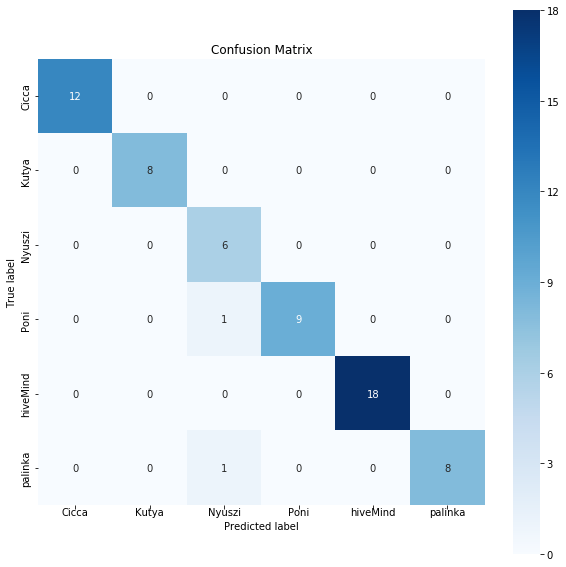

In [0]:
import seaborn as sns

conf = confusion_matrix(test_true, test_preds)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

res = sns.heatmap(conf, annot=True, vmin=0.0, fmt='d', cmap = plt.get_cmap('Blues'))

plt.yticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.ylim([0, 6])
plt.ylabel('True label')
plt.xticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.xlim([0, 6])
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

res.invert_yaxis()

plt.show()
plt.close()

*NOTE*: The fact that the network managed to achieve 100% accuracy on both the train and valdiation datasets, and 96% on the test dataset indicates that a) the network might be too big/complex for the task at hand, and b) the dataset migh be too homogenous.

As the end goal is to be able to is to classify many more persons, not just 6, I'm not going to attempt to reduce the complexity of InceptionV3.